In [107]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import datetime 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler



In [108]:
data = pd.read_csv("/Users/ayhancagan/Desktop/Stock Price Project/MSFT.csv",parse_dates=['Date'], index_col = "Date").asfreq('B')
data 
# data = https://finance.yahoo.com/quote/MSFT/history?period1=511056000&period2=1693785600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1.031789e+09
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,3.081600e+08
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,1.331712e+08
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,6.776640e+07
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,4.789440e+07
...,...,...,...,...,...,...
2023-08-28,325.660004,326.149994,321.720001,323.700012,323.700012,1.480850e+07
2023-08-29,321.880005,328.980011,321.880005,328.410004,328.410004,1.928460e+07
2023-08-30,328.670013,329.809998,326.450012,328.790009,328.790009,1.522210e+07


In [109]:
data.isnull().sum()

Open         332
High         332
Low          332
Close        332
Adj Close    332
Volume       332
dtype: int64

In [110]:
# Iterate through each column (Target) in the dataframe
for Target in data.columns:
    # Interpolate missing values in the current column using linear method
    data[Target] = data[Target].interpolate(method='linear')
    # The linear interpolation method fills missing values by estimating them based on adjacent data points in a linear manner.


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9777 entries, 1986-03-13 to 2023-09-01
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9777 non-null   float64
 1   High       9777 non-null   float64
 2   Low        9777 non-null   float64
 3   Close      9777 non-null   float64
 4   Adj Close  9777 non-null   float64
 5   Volume     9777 non-null   float64
dtypes: float64(6)
memory usage: 534.7 KB


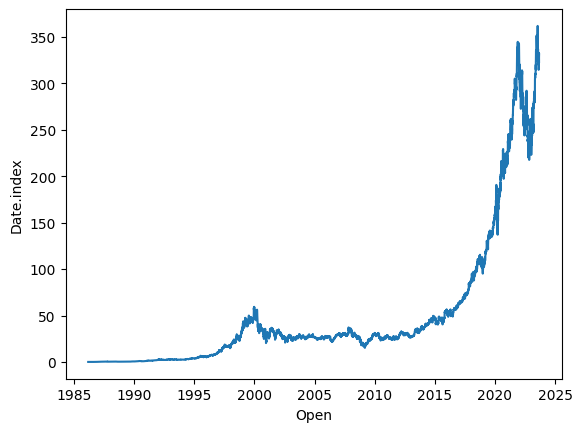

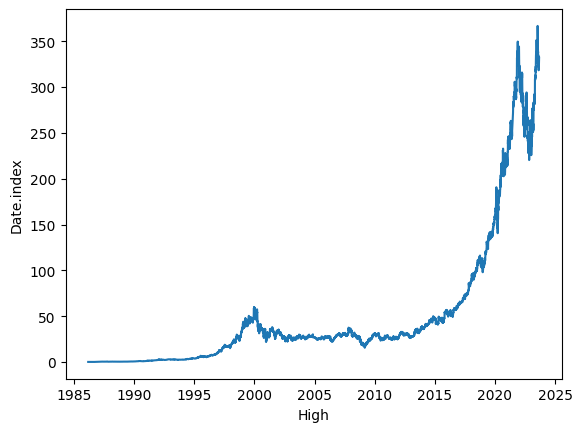

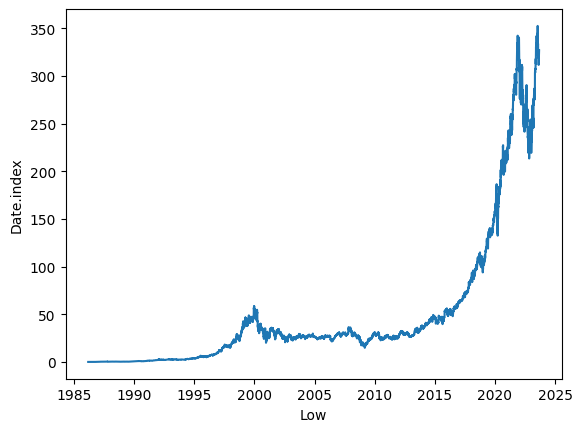

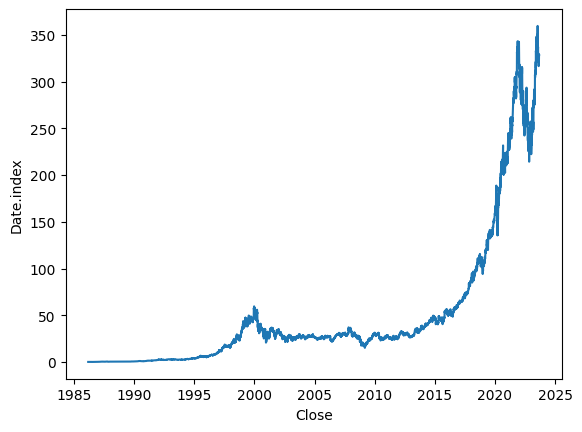

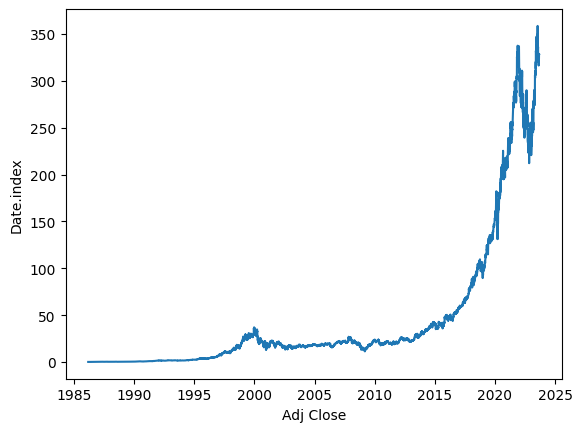

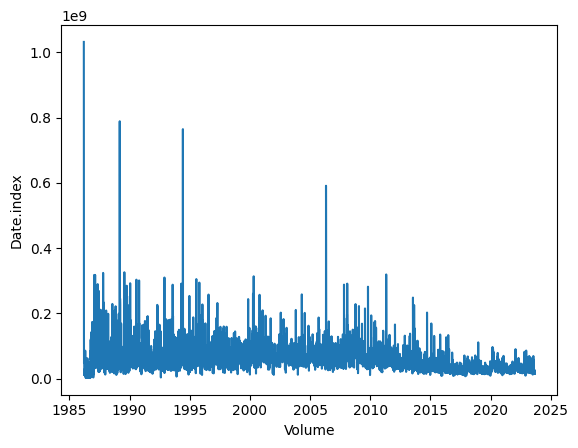

In [112]:
for Target in data.columns:
    plt.plot(data.index,data[Target],label=Target)
    plt.xlabel(Target)  
    plt.ylabel('Date.index')
    plt.legend
    plt.show()

In [113]:
# A function that divides the dataframe into windows and extracts data within the window
# It creates a time window using the first and last dates provided.
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert the first and last dates to datetime objects
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)

    # Set the target date as the first date
    target_date = first_date
    
    # Lists to store dates, X, and Y data
    dates = []
    X, Y = [], []

    # A flag to terminate the loop
    last_time = False
    while True:
        # Select a subset with n+1 days before the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        # If the length of the subset is not n+1, raise an error and exit the function
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # Get the values from the 'Close' column of the subset
        values = df_subset['Close'].to_numpy()
        # x: first n values, y: the last value
        x, y = values[:-1], values[-1]

        # Append the date and data to the respective lists
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Calculate the date of the next week
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        # If it's the last operation, break the loop
        if last_time:
            break
        
        target_date = next_date

        # Mark the last operation if the target date is equal to the last date
        if target_date == last_date:
            last_time = True
        
    # Create a DataFrame to contain the results
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    # Convert X data to a numpy array and loop to add them in order
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    # Add the target column to the DataFrame
    ret_df['Target'] = Y

    return ret_df

# Generate time-windowed data by specifying the start date and end date
windowed_df = df_to_windowed_df(data, 
                                '2021-03-25',  # Start date
                                '2022-03-23',  # End date
                                n=3)  # Window size


In [114]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:, 0].astype('str')
    middle_matrix = df_as_np[:, 1:-1]
  
    scaler = StandardScaler()
    middle_matrix = scaler.fit_transform(middle_matrix)

    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:,-1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape 



((260,), (260, 3, 1), (260,))

In [115]:
print(X) 

[[[-1.8365681 ]
  [-1.8025647 ]
  [-1.8944858 ]]

 [[-1.7828755 ]
  [-1.8746139 ]
  [-2.0011506 ]]

 [[-1.8544656 ]
  [-1.9806491 ]
  [-1.8596151 ]]

 [[-1.9598253 ]
  [-1.839949  ]
  [-1.9020071 ]]

 [[-1.8200216 ]
  [-1.8820907 ]
  [-2.0179021 ]]

 [[-1.8618948 ]
  [-1.9973016 ]
  [-1.8838878 ]]

 [[-1.9763718 ]
  [-1.8640784 ]
  [-1.6589352 ]]

 [[-1.8439974 ]
  [-1.6404536 ]
  [-1.5440658 ]]

 [[-1.6217973 ]
  [-1.5262623 ]
  [-1.4291965 ]]

 [[-1.5083334 ]
  [-1.4120709 ]
  [-1.4705633 ]]

 [[-1.3948696 ]
  [-1.4531935 ]
  [-1.4008214 ]]

 [[-1.4357303 ]
  [-1.3838633 ]
  [-1.2862937 ]]

 [[-1.3668418 ]
  [-1.2700117 ]
  [-1.1974065 ]]

 [[-1.2537155 ]
  [-1.1816491 ]
  [-1.1953553 ]]

 [[-1.1659158 ]
  [-1.17961   ]
  [-1.1071526 ]]

 [[-1.1638898 ]
  [-1.0919278 ]
  [-1.2062955 ]]

 [[-1.0767663 ]
  [-1.1904856 ]
  [-1.072623  ]]

 [[-1.1746962 ]
  [-1.057602  ]
  [-1.0302311 ]]

 [[-1.0426593 ]
  [-1.0154604 ]
  [-1.0986058 ]]

 [[-1.0007861 ]
  [-1.0834314 ]
  [-1.1150149 ]]



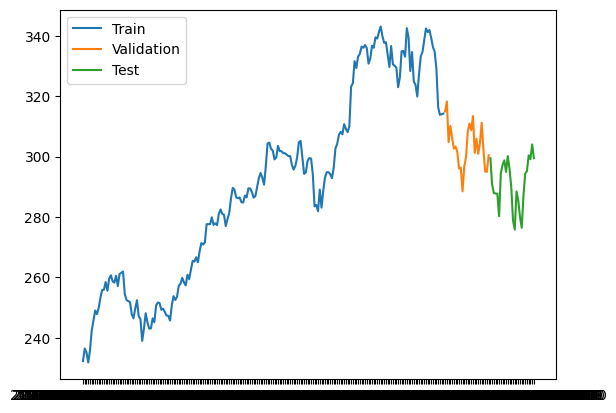

In [116]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])



In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam  
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
print(model.summary())
print(model.evaluate(X_test, y_test))


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                16896     
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 477ms/step - loss: 84849.6250 - mean_absolute_error: 291.1812
[84849.625, 291.18121337890625]


In [118]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,verbose=0)
print(model.evaluate(X_test, y_test))

1/1 [==============================] - 0s 13ms/step - loss: 87.1924 - mean_absolute_error: 7.4296
[87.19242858886719, 7.429633617401123]


7/7 [==============================] - 0s 1ms/step


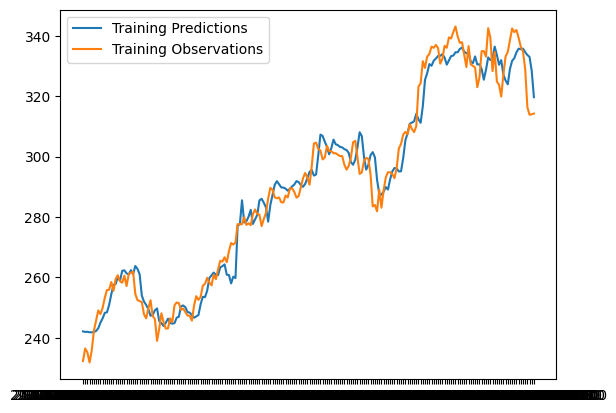

In [119]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations']) 

1/1 [==============================] - 0s 19ms/step


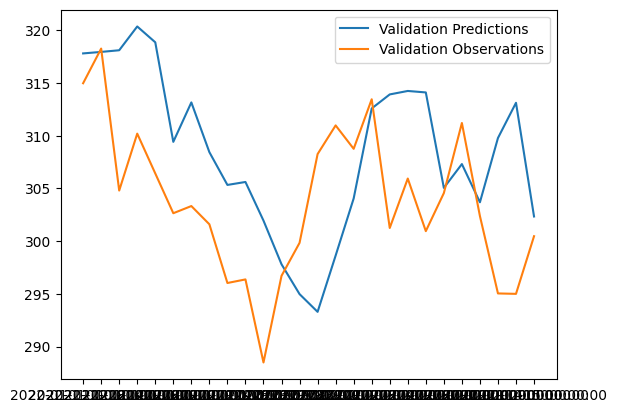

In [120]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 18ms/step


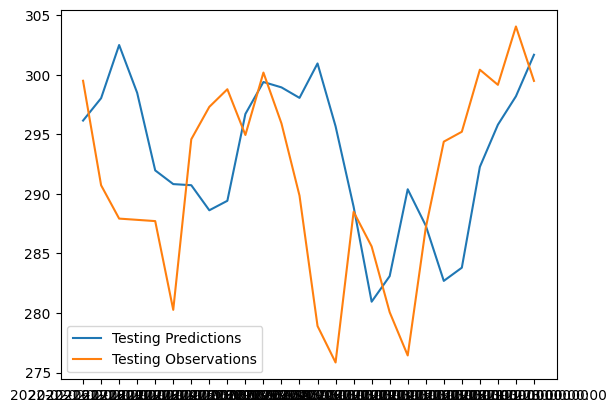

In [121]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()

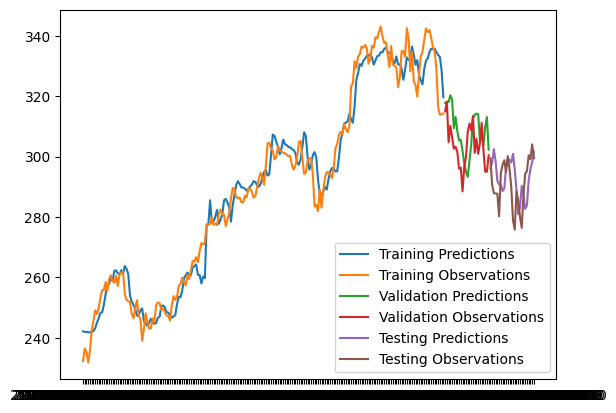

In [122]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

plt.show()

In [123]:
from copy import deepcopy

recursive_predictions = []
# Concatenate the validation and test dates to create a list of all dates for prediction
recursive_dates = np.concatenate([dates_val, dates_test])

# Iterate through the recursive_dates
for target_date in recursive_dates:
    # Create a deep copy of the last window in X_train
    last_window = deepcopy(X_train[-1])
    
    # Predict the next value using the model and flatten the result
    next_prediction = model.predict(np.array([last_window])).flatten()
    
    # Append the next_prediction to the recursive_predictions list
    recursive_predictions.append(next_prediction)
    
    # Update the last value of the last_window with the next_prediction
    last_window[-1] = next_prediction


1/1 [==============================] - 0s 10ms/step


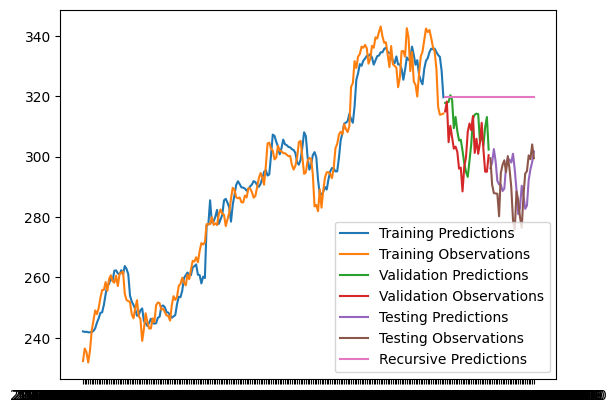

In [124]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])